# Imports 

In [10]:
from pdb import run
from unittest import case
import emcee
import corner
import pickle
from tqdm import tqdm
import numpy as np
from qutip import *
from multiprocess import Pool
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, basinhopping
from IPython.display import display, Math
from scipy.stats import chi2
from protocolsClass import Hamiltonian_Fitter,State
import matplotlib.pyplot as plt
 


# Measurement Data

In [ ]:
ground_meas_old_Nb = np.array([7512786.3, 6847127.7, 6180056.7, 5510661.7, 4837199., 4156107.7, 3459061.2, 2730533.1, 1787541.6]) * 1e-3 # [kHz]
manu_ramsey_meas_old_Nb = np.array([-134296, -133678, -132898, -131896, -130532, -128697, -125952, -124533, -88889]) * 1e-3 # [kHz] previous
best_x_old =  [
        449.8217895516637,
        129.90322492463346,
        -237.05198836433365,
        -11.942209580809898,
        -149.3165679361477,
        1.5721261153027557,
        -0.8193213318825887,
        0.07781602296853966
    ]
ground_meas_Nb = np.array([7560562.0 ,6894745.1 ,6227459.8 , 5557759.9 , 4883861.9 ,4202128.8 , 3504133.1, 2774604.8, 1822491.2]) * 1e-3
manu_ramsey_meas_Nb = np.array([-136547.1, -135922.4, -135196.4, -134203.1, -132831.5, -130986.4, -128470.1, -122551.2, -128756.7])* 1e-3

ground_meas_Ca = [997843.4 ,1090793.4 ,1185442.1 ,1281215.1 ,1377750.3 ,1474814.6 ,1572254.3]
manu_ramsey_meas_Ca = [-27703.3,-27670.2,-27594.3,-27518.5,-27449.3,-27376.6,-27349.6]
d_ground_meas_Ca = np.array([0.0273, 0.0249, 0.0277, 0.0283, 0.0286, 0.0409, 0.0654])# [kHz]
d_manu_ramsey_meas_Ca = np.array([5.6949,5.2385, 6, 5.4, 7.7936, 9.6203, 12.6653])# [kHz]


full_meas_Nb = np.concatenate((ground_meas_Nb,manu_ramsey_meas_Nb))
full_meas_old_Nb = np.concatenate((ground_meas_old_Nb,manu_ramsey_meas_old_Nb))

d_ground_meas_Nb = np.array([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0002, 0.0002, 0.0002])# [kHz]
d_manu_ramsey_meas_Nb = np.array([0.0450, 0.0298, 0.0236, 0.0285, 0.0223,  0.0182, 0.0159, 0.0195, 0.0175])# [kHz]
d_full_meas_Nb = np.concatenate((d_ground_meas_Nb,d_manu_ramsey_meas_Nb))
A_perp_meas_Nb = 55 # [kHz] | Measured through the Raman Rabi experiment
A_perp_meas_Ca = 20 # [kHz] | Measured through the Raman Rabi experiment
A_simu_Nb = np.array([[-436.6,    0.,   -41.3],
                    [  -0.,  -448.4,    0. ],
                    [ -88.5,    0.,   129.8]])

A_simu_Nb = 1e3*np.array([[ 0.43899564,  0.,          0.02076148],
                    [-0.,          0.44172529, -0.        ],
                    [-0.04857903,  0.,          0.12994526]])


exp_id = '_Old_Nb_meas'
exp_id = '_New_Nb_meas'

fitter_ground = Hamiltonian_Fitter(ground_meas_Nb,d_ground_meas_Nb,State.Ground,id = exp_id)
fitter_excited = Hamiltonian_Fitter(ground_meas_Nb + manu_ramsey_meas_Nb,d_manu_ramsey_meas_Nb,State.Excited,id = exp_id)
fitter_full = Hamiltonian_Fitter(full_meas_Nb,d_full_meas_Nb,State.Full, meas_Aperp = A_perp_meas,simu_A= A_simu,id = exp_id)



def _sig_decimals(err, sig_figs=2):
    """
    Return the number of decimals needed to keep `sig_figs`
    significant figures of an uncertainty `err`.

    Example:
    err = 0.0123  -> 3  (0.012 shown with 2 s.f.)
    err = 3.4     -> -1 ( 3  shown with 2 s.f.)
    """
    if err == 0:
        return 0
    exponent = int(np.floor(np.log10(err)))
    return max(0, sig_figs - 1 - exponent)

def pretty_mcmc(flat_samples, labels, sig_figs=2):
    """
    Print median and asymmetric 1-σ errors with only the
    relevant digits for each parameter.
    """
    ndim = flat_samples.shape[1]

    for i in range(ndim):
        p16, p50, p84 = np.percentile(flat_samples[:, i], [16, 50, 84])
        q_minus, q_plus = p50 - p16, p84 - p50
        # Use the larger side as a conservative uncertainty
        err = max(q_minus, q_plus)
        ndp = _sig_decimals(err, sig_figs)

        fmt = f"{{:.{ndp}f}}"
        central = fmt.format(p50)
        low    = fmt.format(q_minus)
        high   = fmt.format(q_plus)

        # build LaTeX string
        txt = (rf"\mathrm{{{labels[i]}}}"
               rf" = {central}_{{-{low}}}^{{+{high}}}")
        display(Math(txt))

# Fitted Values and Guesses

In [ ]:


best_x_ground = [460.5432325817811,-237.3531938224631,149.44397764618174,2.676920410881122,-0.07979116163000531]
best_x_excited = [447.72559654611877,-237.23552163653977,149.53908329962314,6.419823433715284,0.3084357146817395]


guess_full_old = [449.8217895516637,129.90322492463346,-237.05198836433365,-11.942209580809898,-149.3165679361477,1.5721261153027557,-0.8193213318825887,0.07781602296853966]
    
best_x =  [ 4.49821745e+02,  1.29897714e+02 ,-2.37052323e+02, -1.19458723e+01, -1.49320580e+02,  1.57442624e+00, -8.21616775e-01 , 7.88331359e-02]
median_x =  [ 4.49821749e+02,  1.29897911e+02, -2.37052291e+02, -1.19454405e+01, -1.49320418e+02,  1.57449384e+00, -8.21746234e-01,  7.89184735e-02]

# Ground

100%|██████████| 5000/5000 [03:25<00:00, 24.37it/s]


median x :  [ 4.60543324e+02 -2.37353064e+02  1.49442696e+02  2.66784387e+00
 -2.33450040e-02]
best x :  [ 4.60543327e+02 -2.37353059e+02  1.49442653e+02  2.66772257e+00
 -4.58655458e-02]


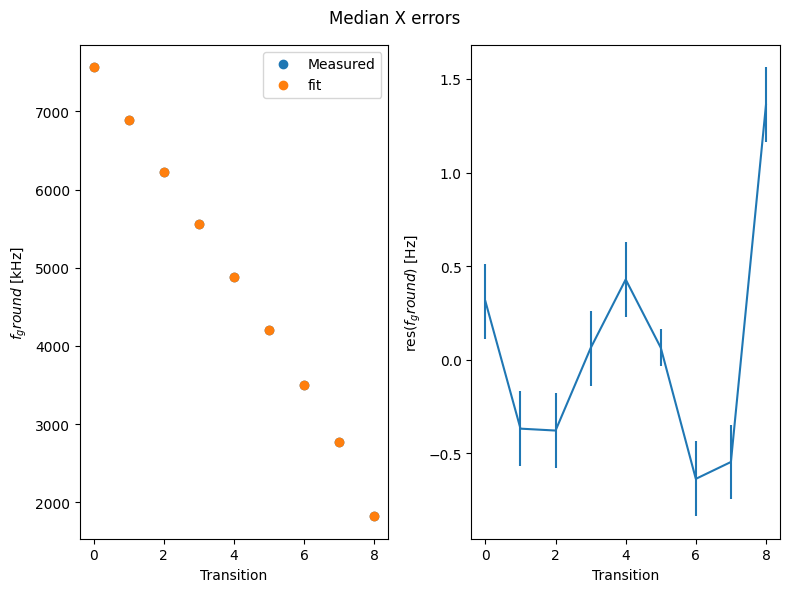

In [13]:
best_x_ground = [460.54324141019123,-237.35318307038176,149.44386682482926,2.6761209774725265,-0.0775147693909858]
fitter_ground.run_MCMC(best_x_ground,nsteps = 5000,var = 0.001)

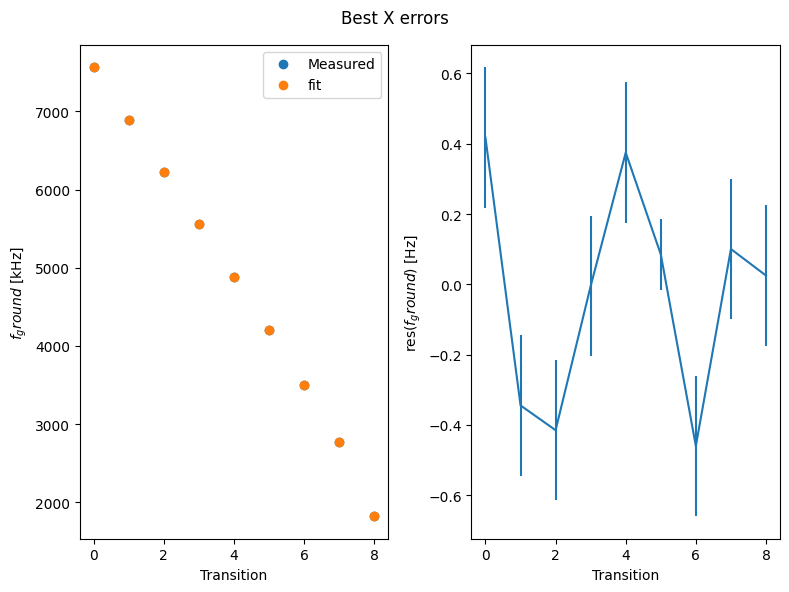

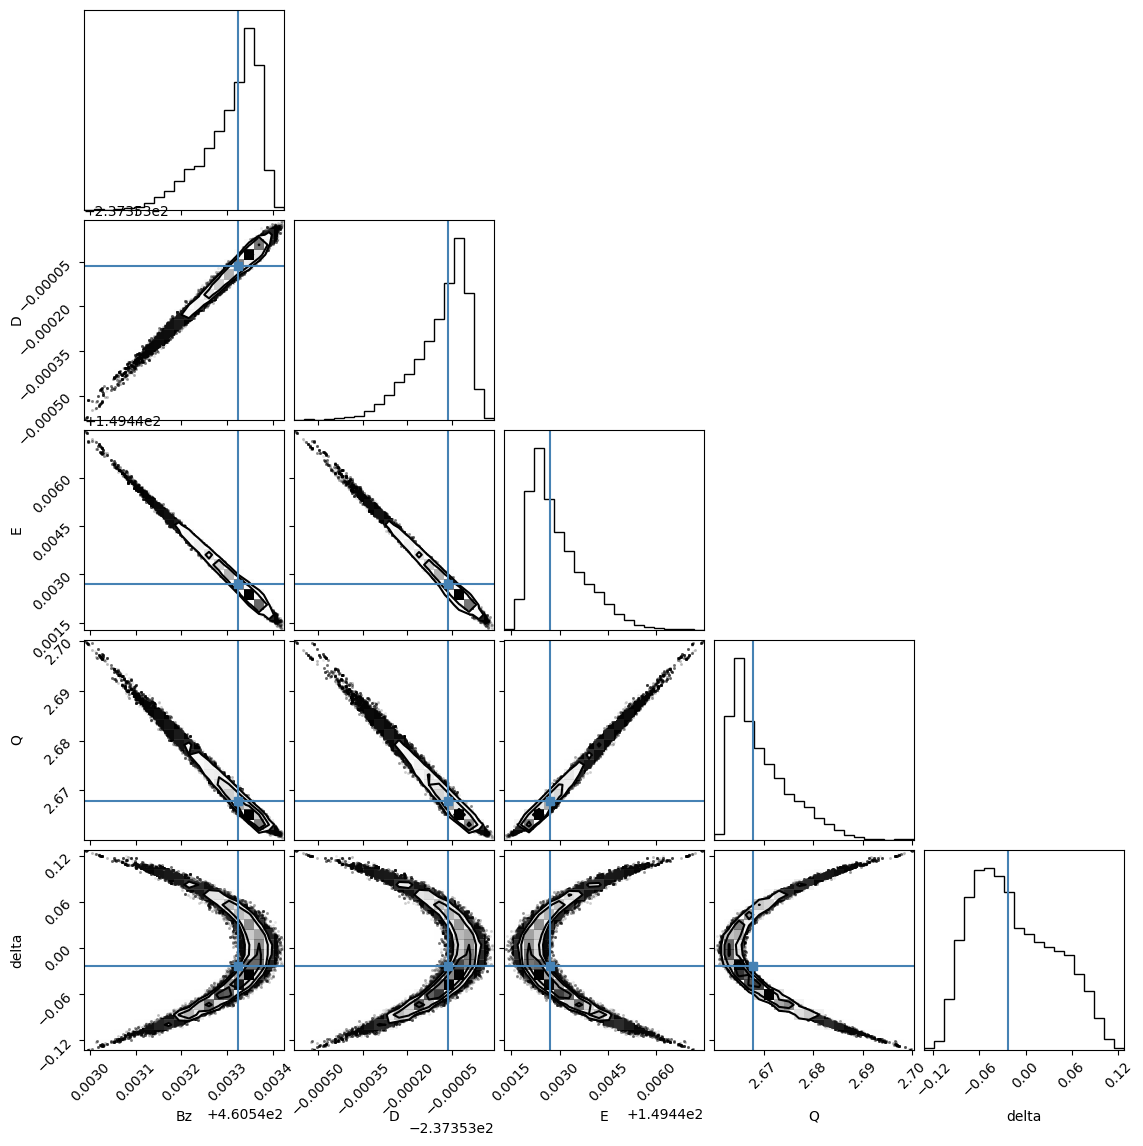

In [18]:
fitter_ground.Save_results()
fitter_ground.Plot_Best()
fitter_ground.Plot_corner()



In [ ]:
fitter_full.Load_results()

QYY[State.Excited.value]: [-30.90188821750403, -30.902438737626774, -30.90192847441311, -30.904208596860343, -30.903543117008976, -30.901927541695557, -30.903912450816584, -30.903507340330137, -30.903324833942808, -30.902392145359197, -30.903360184119656, -30.901943849251413, -30.90331127408886, -30.902978333353293, -30.903522139904464, -30.90286826363116, -30.90163329879076, -30.903303436267063, -30.901572263370635, -30.903802431320077, -30.901949286561788, -30.903829134129605, -30.902725628265323, -30.902277258566887, -30.902953158948453, -30.903503025736036, -30.904230907112424, -30.902595837081872, -30.90148931474936, -30.90476147826752, -30.902496512302662, -30.90262717556052, -30.902489230448364, -30.90382743538696, -30.90204816496034, -30.903273456277912, -30.903938207014168, -30.902927216931563, -30.902565009976925, -30.9024112448875, -30.9035489333033, -30.901251842212698, -30.90202531887184, -30.903268657940384, -30.903272069211578, -30.9022228103223, -30.902497679048064, -30

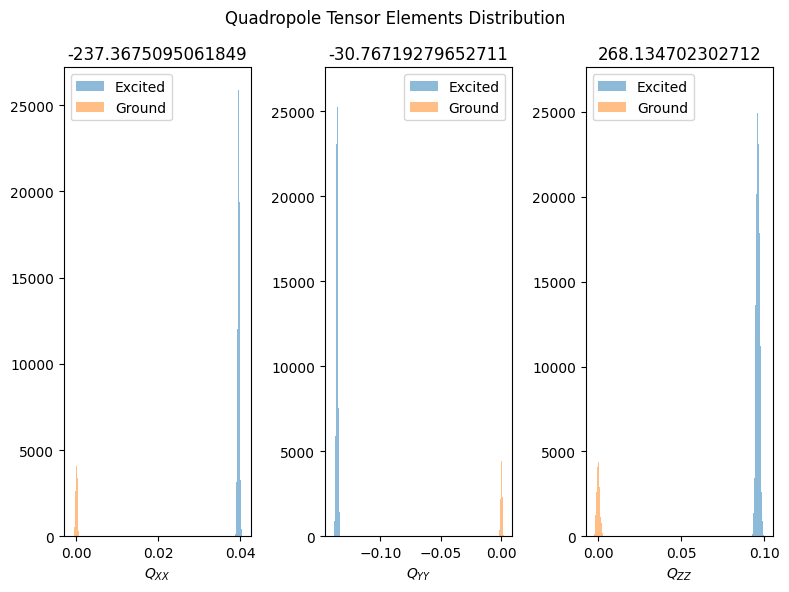

In [ ]:
fitter_ground.Plot_Quadropole()

# excited

100%|██████████| 5000/5000 [06:27<00:00, 12.90it/s]


median x :  [ 4.47732398e+02 -2.37224269e+02  1.49447063e+02  6.11346728e+00
  1.23866656e-01]
best x :  [ 4.47731369e+02 -2.37225938e+02  1.49460950e+02  6.17152451e+00
  2.07664678e-01]


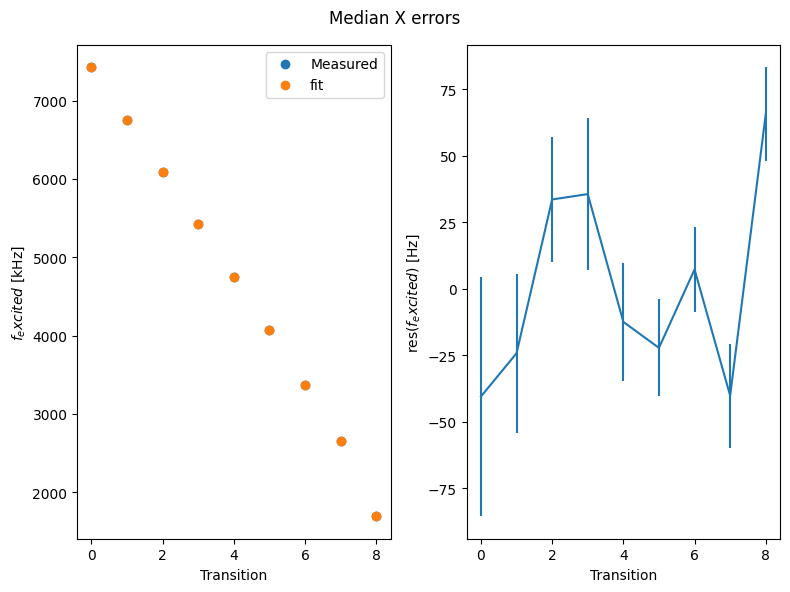

In [4]:
best_x_excited = [447.72559654611877,-237.23552163653977,149.53908329962314,6.419823433715284,0.3084357146817395]
fitter_excited.run_MCMC(best_x_excited,nsteps=5000)


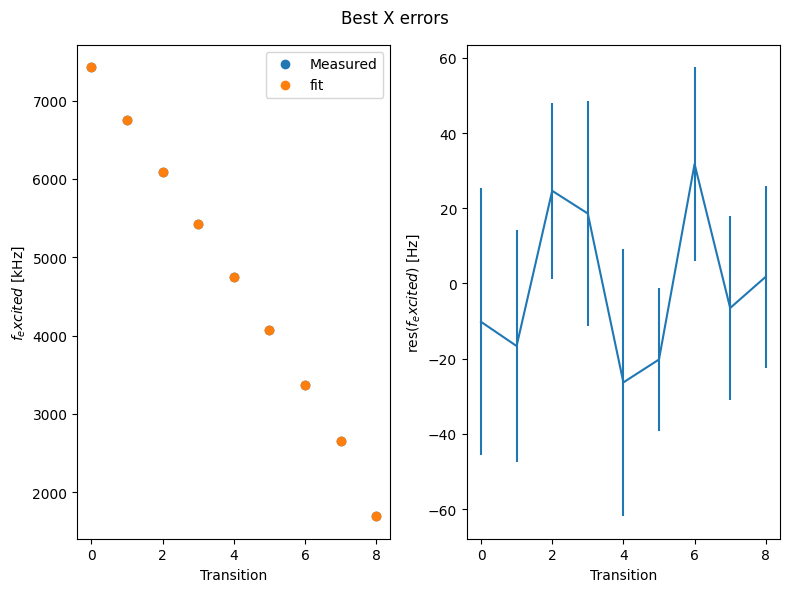

In [ ]:
fitter_excited.Plot_Best()

In [6]:
fitter_excited.Save_results()

In [19]:
fitter_excited.Load_results()

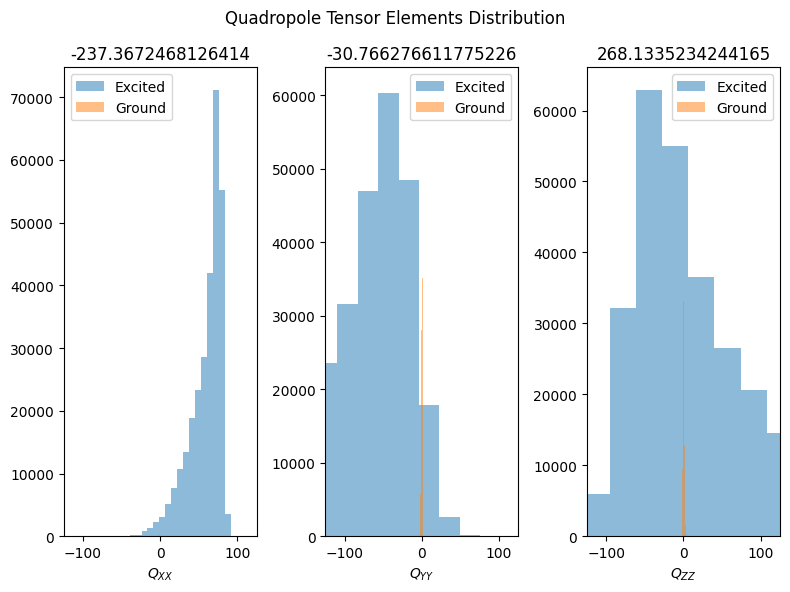

In [20]:
fitter_excited.Plot_Quadropole()


# Full

100%|██████████| 5000/5000 [06:37<00:00, 12.59it/s]


median x :  [ 4.54132228e+02  1.33490418e+02 -2.37296771e+02 -4.33962228e+00
 -1.49433017e+02  1.42961618e+00 -7.29111657e-01  7.27944018e-02]
best x :  [ 4.54132292e+02  1.33489003e+02 -2.37296750e+02 -4.33963076e+00
 -1.49433063e+02  1.43078671e+00 -7.29835662e-01  7.28926197e-02]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

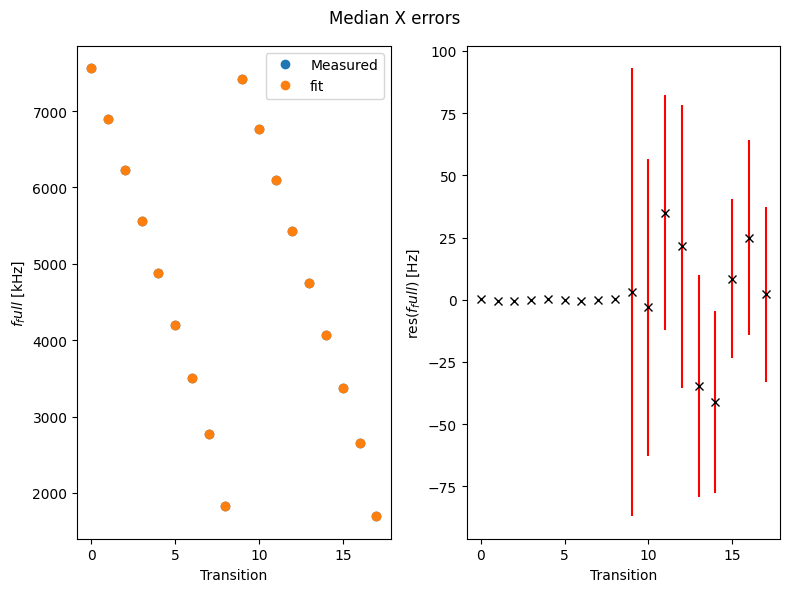

In [12]:
best_x =  [ 4.60735120e+02 , 1.33454486e+02 ,-2.37473628e+02 ,149.5887879e+00,
 2.677151815e+00 , 1.17723572e+00 ,-8.98114801e-01,  2.22202185e-03]
best_x = [ 4.54105879e+02 , 1.33576768e+02 ,-2.37322064e+02 ,-4.56419403e+00,
 -1.49445865e+02,  1.17575176e+00, -8.95192592e-01 , 1.53291163e-03]
best_x =  [ 4.54105995e+02 , 1.33573315e+02, -2.37322081e+02 ,149,2.677, -0.08, 0.1 , 0.001,0]

best_x = [ 4.54131243e+02,  1.33490645e+02 ,-2.37297266e+02 ,-4.34098426e+00,
 -1.49434569e+02,  1.42745043e+00, -7.84097996e-01 , 7.24745420e-02]

fitter_full = Hamiltonian_Fitter(full_meas,d_full_meas,State.Full, meas_Aperp = A_perp_meas,simu_A= A_simu,id = exp_id)

fitter_full.run_MCMC(best_x,nwalkers=64,nsteps = 5000,var = 0.01)

In [14]:
fitter_full.Load_results()

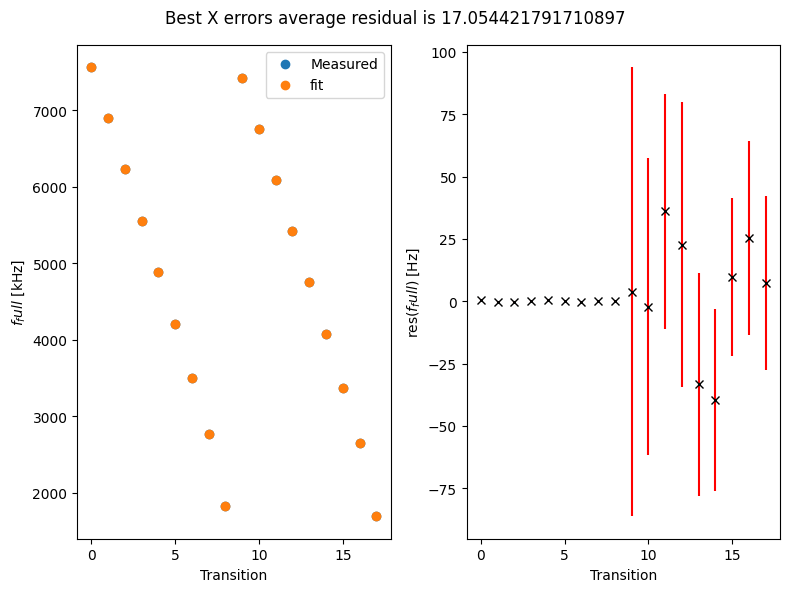

In [13]:
fitter_full.Plot_Best()

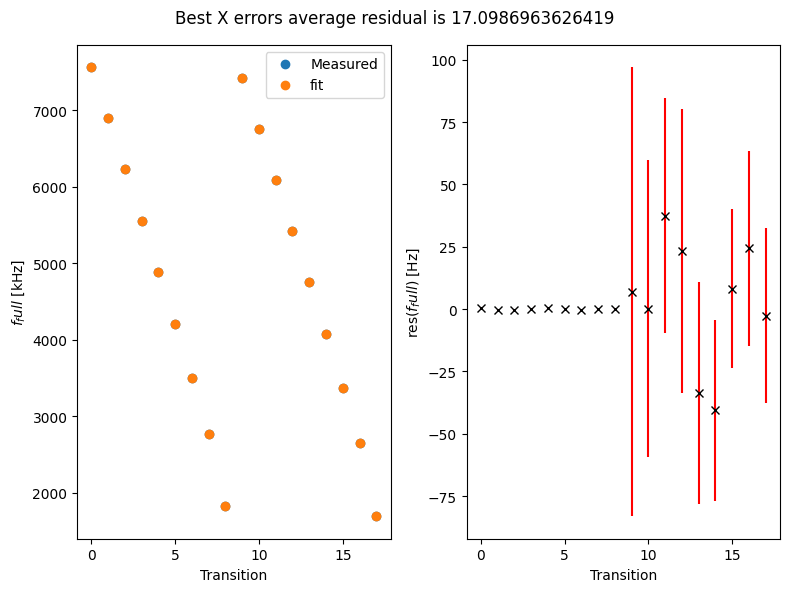

In [15]:
fitter_full.Plot_Best()

c:\Users\manipp4\Documents\Leons_stuff\Spectroscopy_Hamiltonian_fitter-\protocolsClass.py:252: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(meas_to_plot[:9], 'o', marker = 'v', label= r"$\omega^{\downarrow}_{{n(n+1)}/2\pi}$", color = 'orange')
c:\Users\manipp4\Documents\Leons_stuff\Spectroscopy_Hamiltonian_fitter-\protocolsClass.py:253: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(meas_to_plot[9:], 'o', marker = '^', label= r"$\omega^{\uparrow}_{{n(n+1)}/2\pi}$", color = 'blue')
c:\Users\manipp4\Documents\Leons_stuff\Spectroscopy_Hamiltonian_fitter-\protocolsClass.py:260: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorb

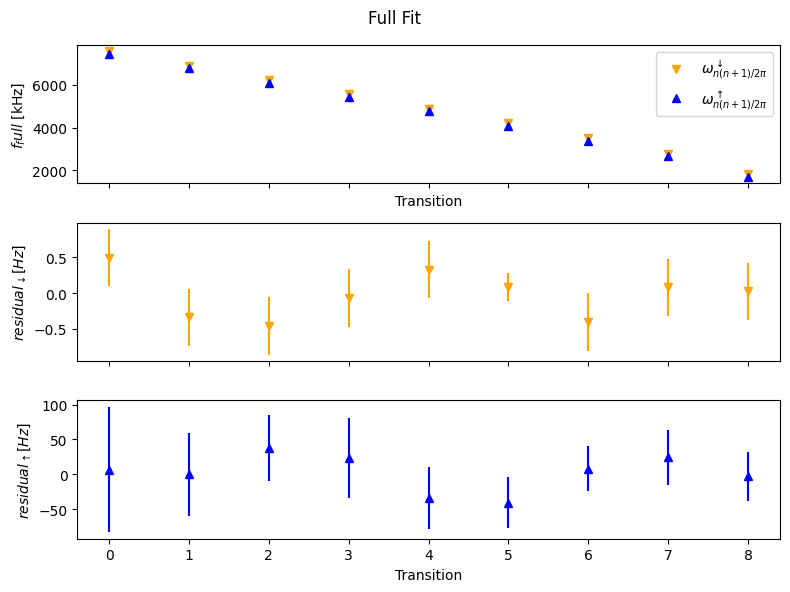

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
fitter_full.Plot_full(fitter_full.best_x['full'])
fitter_full.Print_values()

In [ ]:
samples = fitter_ground.results['ground']
# labels = ["Bz", "A", "D", "S1", "S2", "delta", "alpha", "Dz"]
labels = ["Bz", "D", "E", "Q", "delta"]

pretty_mcmc(samples,labels,sig_figs=1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Quadropole Plotting

[[ 2.8000000e-04 -2.3736719e+02  1.3000000e-04]
 [ 9.2000000e-04 -3.0766090e+01  4.6000000e-04]
 [ 6.0000000e-04  2.6813330e+02  1.2000000e-03]]


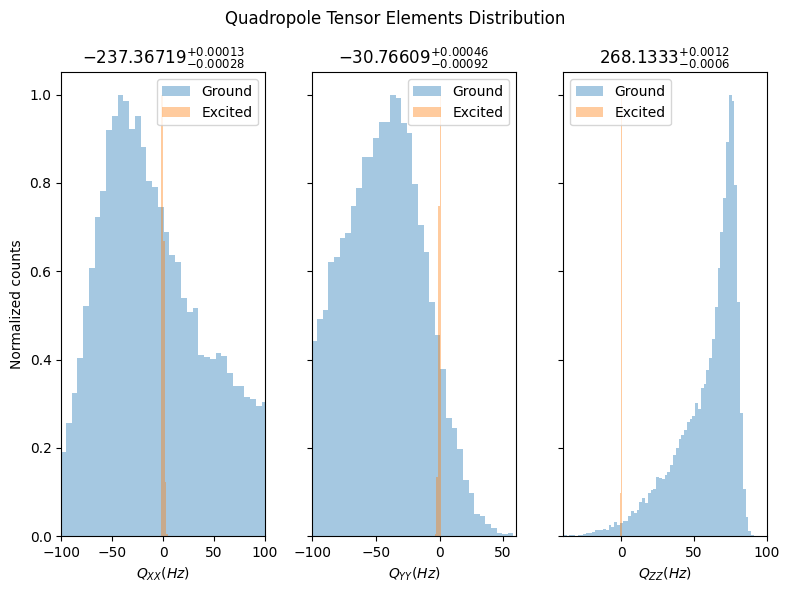

In [3]:

fitter_full = Hamiltonian_Fitter(full_meas,d_full_meas,State.Full, meas_Aperp = A_perp_meas,simu_A= A_simu,id = exp_id)
fitter_full.Load_results()
#fitter_full.Plot_corner()
fitter_full.Plot_Quadropole()

AttributeError: 'NoneType' object has no attribute 'get_chain'